FFNN model

In [5]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

# For hyperparameter tuning
import keras_tuner
from tensorflow import keras

# Unused atm
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from mlxtend.plotting import heatmap

# Stats library
import statsmodels.api as sm

#from .autonotebook import tqdm as notebook_tqdm

# shap
import shap

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

random.seed(2)
%matplotlib inline

In [6]:
greeks = pd.read_csv('/Users/akhilaganti/UCB_MIDS_w207/Final_Project/greeks.csv')
train = pd.read_csv('/Users/akhilaganti/UCB_MIDS_w207/Final_Project/train.csv')
test = pd.read_csv('/Users/akhilaganti/UCB_MIDS_w207/Final_Project/test.csv')

greeks.columns = map(str.lower, greeks.columns)
train.columns = map(str.lower, train.columns)
test.columns = map(str.lower, test.columns)

print('greeks data:', greeks.shape)
print('train data:', train.shape)
print('test data:', test.shape)

# Merge train and greeks to get all columns in the same DataFrame
#df = pd.merge(train, greeks, on='id')

greeks data: (617, 6)
train data: (617, 58)
test data: (5, 57)


In [7]:
# One-hot encode EJ so it could be used in tSNE or PCA
train = train.join(pd.get_dummies(train['ej'], dtype=int))
train.drop(['ej'], axis=1, inplace=True)

# Binary target variable
target_variable = train['class']
features_variable = train.drop(['class', 'id'], axis=1)

# Fill in NaN values via KNNImputer
imputer = KNNImputer(n_neighbors=2)
features_variable = pd.DataFrame(imputer.fit_transform(features_variable))

In [4]:
#train.dropna(axis=0, inplace=True)
train

,id,ab,af,ah,am,ar,ax,ay,az,bc,...,fs,gb,ge,gf,gh,gi,gl,class,A,B
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,0,1
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,0,1
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,fd1dd68d51b4,0.175193,2607.26686,85.200147,7.067354,8.138688,4.030845,0.025578,3.396778,1.229900,...,1.395238,16.911036,246.093155,10960.364830,38.380254,41.007968,21.978000,0,1,0
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0,1,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0,0,1
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0,1,0


In [8]:
# Use PCA to reduce features
# Split into Train and Test
num_features = 30
data_split = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(features_variable, target_variable, test_size = data_split,
                                                            stratify=target_variable, random_state=0)
# Standardize values via StandardScaler
sc = StandardScaler().fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# PCA
pca = PCA(n_components = num_features)
pca.fit(X_train_std)
X_train_pca = pd.DataFrame(pca.transform(X_train_std))
X_test_pca = pd.DataFrame(pca.transform(X_test_std))


In [9]:
display(X_train.head())

# Display old features shape
display(features_variable.shape)

# Display new tSNE features shape
display(X_train.shape)

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
142,0.444392,2673.56276,104.586381,31.967234,8.138688,6.041838,0.025578,11.595680,1.229900,5525.244800,...,1.46392,0.474110,20.427192,72.611063,1448.445726,41.053793,83.579712,0.045692,0.0,1.0
479,0.431573,2926.50237,85.200147,31.276603,8.138688,3.455010,0.025578,13.057744,4.926628,4714.755180,...,1.63357,0.067730,16.734298,72.611063,10522.503370,24.636741,118.579488,0.062274,0.0,1.0
24,0.158101,3257.64549,138.368592,8.640630,18.385464,4.146012,0.182700,4.099451,7.836220,3633.584335,...,1.82323,0.433472,8.311337,72.611063,1884.728169,48.039971,37.160256,21.978000,1.0,0.0
467,0.341840,1570.03913,85.200147,28.932174,8.138688,3.933396,0.038671,10.599964,1.229900,4091.391360,...,1.65271,0.203190,6.623024,72.611063,14687.686420,15.003072,43.996632,0.051449,0.0,1.0
402,0.299110,3835.33700,85.200147,14.314334,8.138688,5.297682,0.048720,13.183784,1.229900,6679.911660,...,1.25396,0.108368,27.292068,388.351474,9155.805516,28.994032,94.194356,21.978000,1.0,0.0


(617, 57)

(493, 57)

Model

In [10]:
def build_model(hidden_layer_sizes=[],
                activation='relu',
                optimizer='Adam',
                learning_rate=0.01,
                dropout_rate=0.1):
    
    """Build a binary-class logistic regression model using Keras.

    Args:
      hidden_layer_sizes: A list with the number of units in each hidden layer.
      activation: The activation function to use for the hidden layers.
      optimizer: The optimizer to use (SGD, Adam).
      learning_rate: The desired learning rate for the optimizer.

    Returns:
      model: A tf.keras model (graph).
    """
    
    # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # Use Keras Sequential API to build the model
    model = tf.keras.Sequential()
    
    # Create hidden layers with dropout layers
    for layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(units=layer_size,activation=activation))
        
        # Add dropout layer for regularization
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
        
    # Create output layer
    model.add(tf.keras.layers.Dense(
          units=1,  # output dim for binary classification problem
          use_bias=True,
          activation='sigmoid', # sigmoid rather than softmax for a binary classification problem
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
          name='Output'
    ))
  
    # Specify optimizer
    if optimizer == 'Adam':
                selected_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        selected_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    # Using Binary Crossentropy loss
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                optimizer=selected_optimizer, 
                metrics=[tf.keras.metrics.binary_accuracy])

    return model


In [11]:
def train_and_evaluate(hidden_layer_sizes=[],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       dropout_rate=0.1,
                       num_epochs=5,
                       num_folds=10):

  # Address the class imbalances by using class weights.
  # Scaling by total/2 helps keep the loss to a similar magnitude.
  # The sum of the weights of all examples stays the same.
    weight_for_0 = (1 / Y_train.value_counts()[0]) * (Y_train.size / 2.0)
    weight_for_1 = (1 / Y_train.value_counts()[1]) * (Y_train.size / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}
    
  # Create a k-fold object with k subsets
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=0)

  # Create a list to hold the accuracy for each k-fold.
    accuracy_history = []
    
  # Iterate over the k subsets
    for train_index, test_index in kfold.split(X_train):
        X_train_k, X_test_k = X_train.iloc[train_index], X_train.iloc[test_index]
        Y_train_k, Y_test_k = Y_train.iloc[train_index], Y_train.iloc[test_index]
 
        # Build the model.
        model = build_model(hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate,
                      dropout_rate=dropout_rate)

        # Train the model.
        print('Training...')
        history = model.fit(
            x=X_train_k,                # our binary training examples
            y=Y_train_k,                # corresponding binary labels
            epochs=num_epochs,        # number of passes through the training data
            batch_size=32,            # mini-batch size for SGD
            validation_split=0.2,     # use a fraction of the examples for validation
            verbose=0,                # do not display progress output during training
            class_weight=class_weight # use the calculated class weights to address the imbalance
            )

        ######
        #
        # Do you run evaluate on (X_test, Y_test) or (X_test_k, Y_test_k)?
        #
        ######
        
        # Calculate the accuracy of the model
        test_accuracy = model.evaluate(x=X_test, y=Y_test, verbose=0,
                                 return_dict=True)['binary_accuracy']

        print(f'Accuracy: {test_accuracy}')
        
        # Add the accuracy to the history list
        accuracy_history.append(test_accuracy)
        
        # Plot the loss and accuracy
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
        ax1, ax2 = axes.ravel()

        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        ax1.plot(train_loss, label='train_loss')
        ax1.plot(val_loss, label='validation loss')
        ax1.set_xticks(range(num_epochs))
        ax1.set_xlabel('Train epochs')
        ax1.set_xticks(np.arange(0, num_epochs+1, 10.0))
        ax1.legend()

        train_accuracy = history.history['binary_accuracy']
        val_accuracy = history.history['val_binary_accuracy']
        ax2.plot(train_accuracy, label='train_accuracy')
        ax2.plot(val_accuracy, label='validation accuracy')
        ax2.set_xticks(range(num_epochs))
        ax2.set_xlabel('Train epochs')
        ax2.set_xticks(np.arange(0, num_epochs+1, 10.0))
        ax2.legend()

        plt.show()
    
    # Print the model summary.
    print(model.summary())
    
    # Print the average accuracy of the k folds.
    print(f'Average Accuracy: {sum(accuracy_history) / len(accuracy_history)}')

In [12]:
def build_and_tune_model(hp):
    
    # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # Use Keras Sequential API to build the model
    model = tf.keras.Sequential()
    
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f'units_{i}', min_value=5, max_value=100, step=5),
            activation=hp.Choice('activation', ['relu', 'tanh'])
            ))        
        
    # Choose whether to include a dropout layer and tune the dropout rate
    if hp.Boolean('dropout'):
        model.add(tf.keras.layers.Dropout(rate=(hp.Int('dropout_rate', min_value=10, max_value=50, step=5))*0.01))
        
    # Create output layer
    model.add(tf.keras.layers.Dense(
          units=1,  # output dim for binary classification problem
          use_bias=True,
          activation='sigmoid', # sigmoid rather than softmax for a binary classification problem
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
          name='Output'
    ))

    # For tuning the learning rate
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")              
                  
    # Specify optimizer

    # Only using Adam optimizer if using PCA.
    optimizer = 'Adam'
    
    if optimizer == 'Adam':
        selected_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        selected_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    # Using Binary Crossentropy loss
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                optimizer=selected_optimizer, 
                metrics=[tf.keras.metrics.binary_accuracy])

    return model

# Tune the model
build_and_tune_model(keras_tuner.HyperParameters())

# Set up tuner
tuner = keras_tuner.RandomSearch(
    hypermodel=build_and_tune_model,
    objective="val_loss",
    max_trials=30,
    executions_per_trial=3,
    overwrite=True,
    directory="my_dir",
    project_name="ICR",
)

# Display the tuner search space
tuner.search_space_summary()

# Start tuning - Can specify the number of epochs here.
tuner.search(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test))

# Report tuning results
tuner.results_summary()

Trial 30 Complete [00h 00m 44s]
val_loss: 0.45816315213839215

Best val_loss So Far: 0.42561858892440796
Total elapsed time: 00h 20m 41s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir/ICR
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 02 summary
Hyperparameters:
num_layers: 3
units_0: 40
activation: relu
dropout: True
lr: 0.0012104165274262825
units_1: 5
dropout_rate: 25
units_2: 5
Score: 0.42561858892440796

Trial 06 summary
Hyperparameters:
num_layers: 3
units_0: 30
activation: tanh
dropout: False
lr: 0.006404687722635315
units_1: 50
dropout_rate: 45
units_2: 65
Score: 0.4372337957223256

Trial 19 summary
Hyperparameters:
num_layers: 3
units_0: 45
activation: relu
dropout: True
lr: 0.00015472495698685396
units_1: 55
dropout_rate: 45
units_2: 50
Score: 0.43923534949620563

Trial 26 summary
Hyperparameters:
num_layers: 2
units_0: 95
activation: tanh
dropout: False
lr: 0.00977060690028708
units_1: 55
dropout_rate: 10
units_2: 40
Score:

Training...
Accuracy: 0.846774160861969


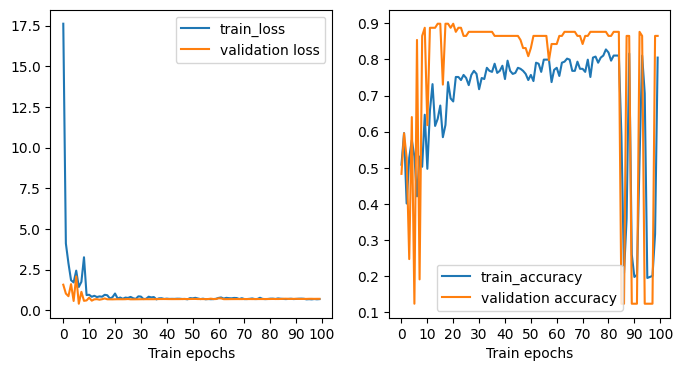

Training...
Accuracy: 0.17741934955120087


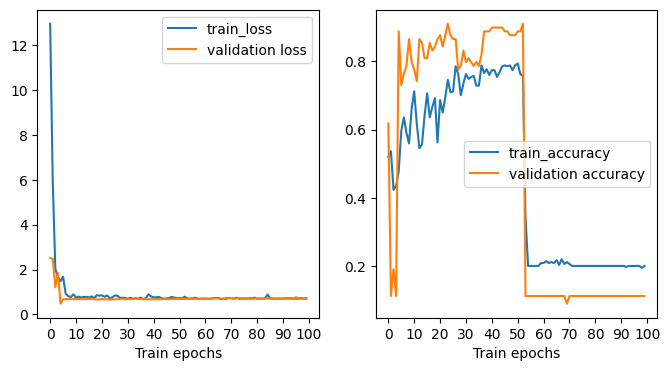

Training...
Accuracy: 0.19354838132858276


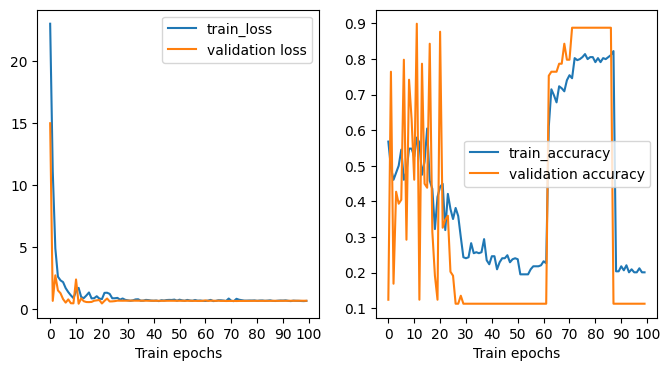

Training...
Accuracy: 0.17741934955120087


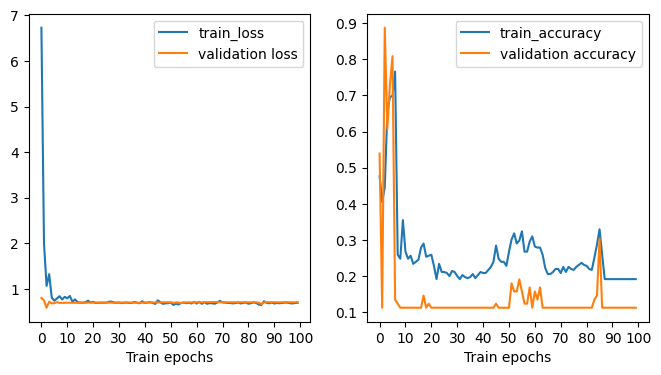

Training...
Accuracy: 0.17741934955120087


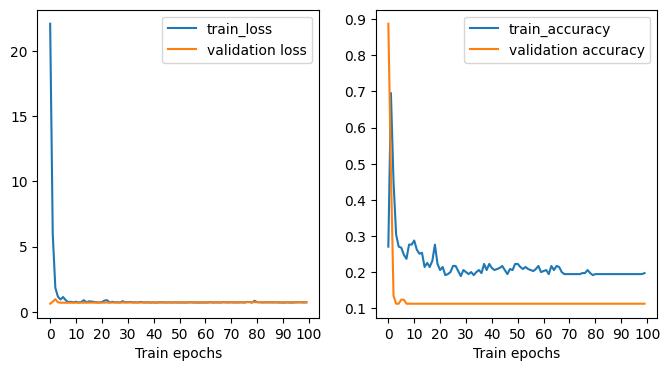

Training...
Accuracy: 0.8306451439857483


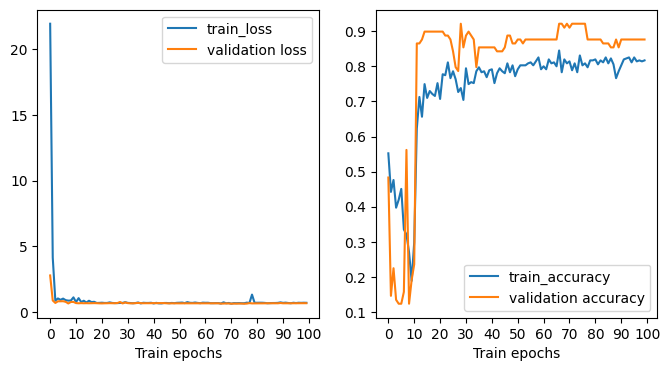

Training...
Accuracy: 0.8306451439857483


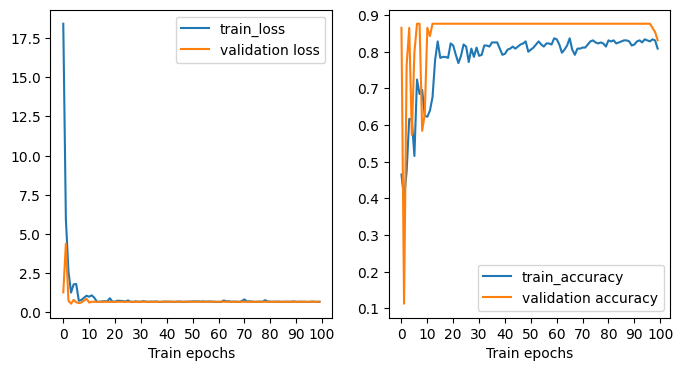

Training...
Accuracy: 0.8387096524238586


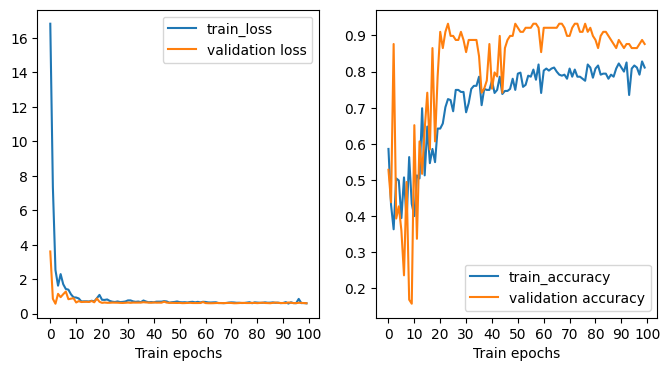

Training...
Accuracy: 0.17741934955120087


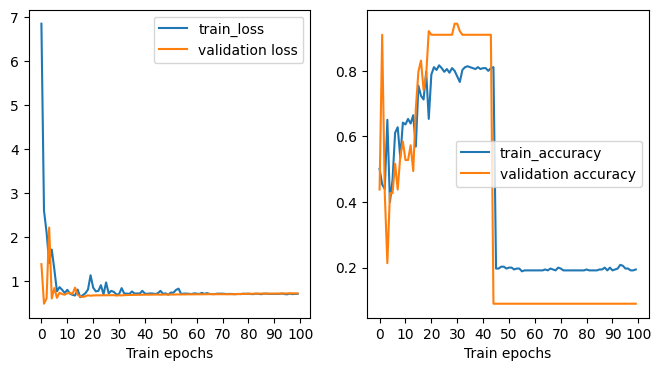

Training...
Accuracy: 0.17741934955120087


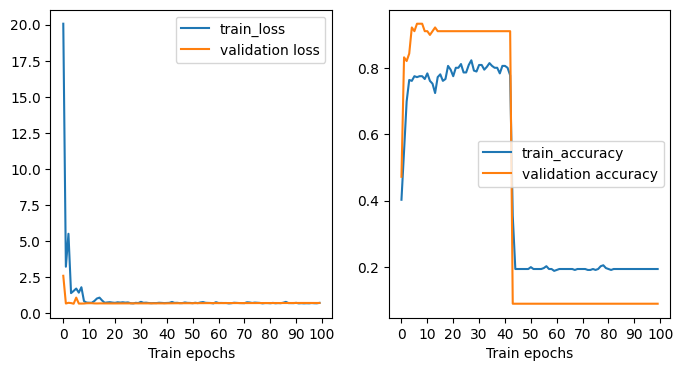

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                5510      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 6,481
Trainable params: 6,481
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.44274192303419113


In [13]:
train_and_evaluate(
    hidden_layer_sizes=[95,10],
    activation='relu',
    optimizer='Adam',
    learning_rate=0.0012104,
    dropout_rate=0.25,
    num_epochs=100,
    num_folds=10)

Training...
Accuracy: 0.6129032373428345


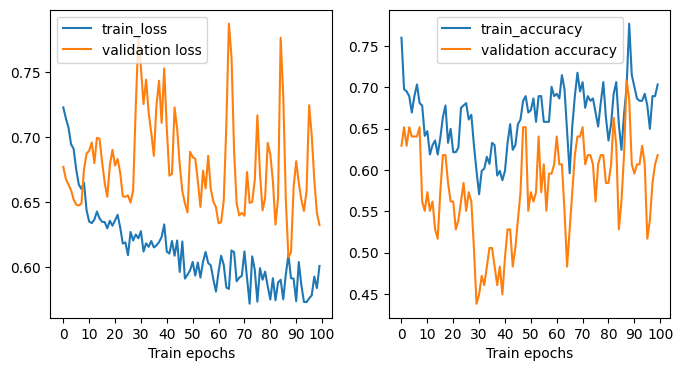

Training...
Accuracy: 0.7096773982048035


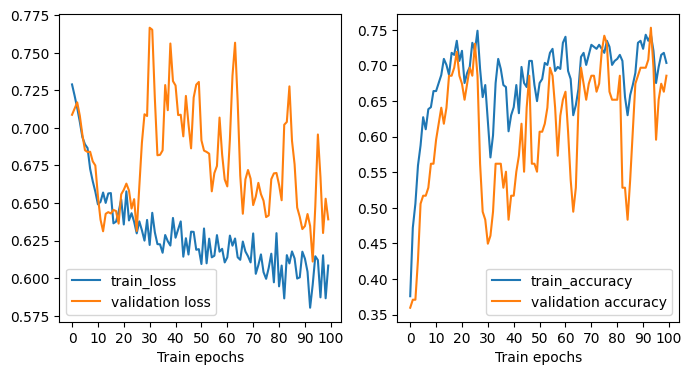

Training...
Accuracy: 0.6693547964096069


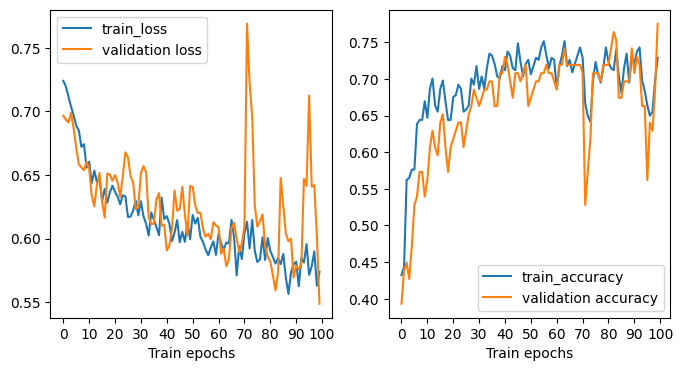

Training...
Accuracy: 0.5887096524238586


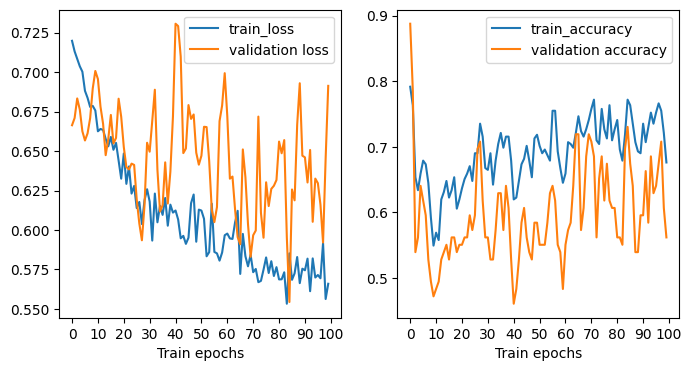

Training...
Accuracy: 0.6532257795333862


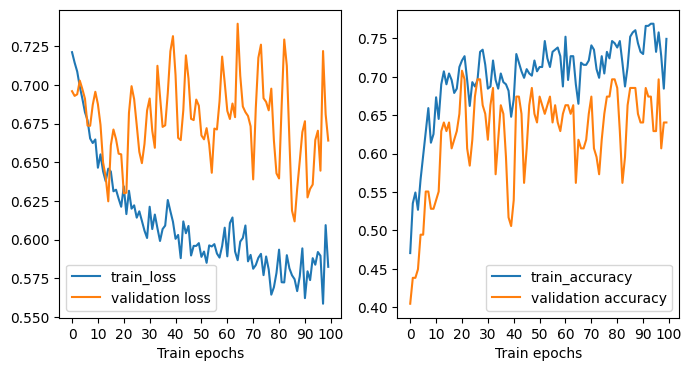

Training...
Accuracy: 0.6290322542190552


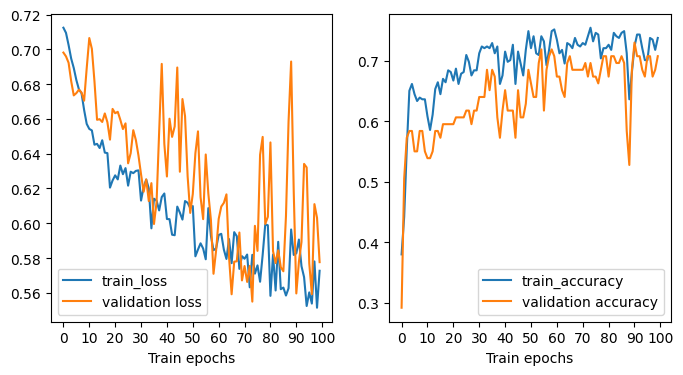

Training...
Accuracy: 0.6935483813285828


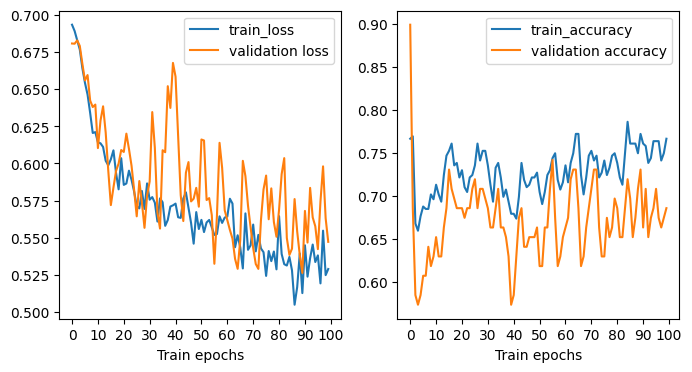

Training...
Accuracy: 0.7177419066429138


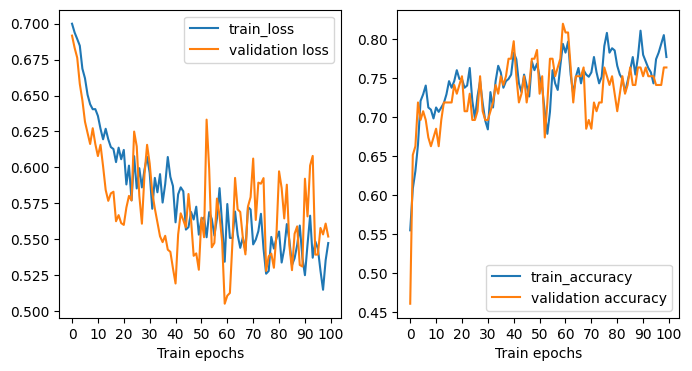

Training...
Accuracy: 0.6451612710952759


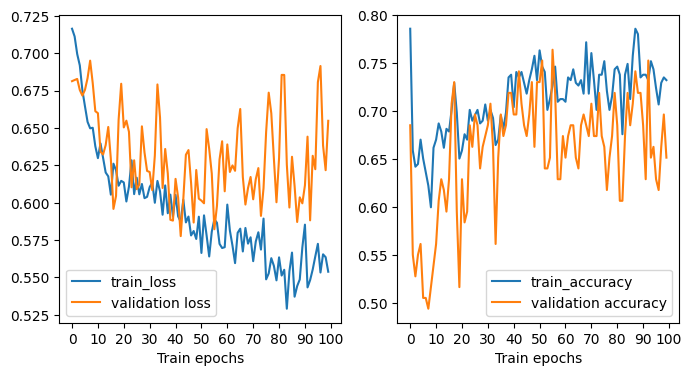

Training...
Accuracy: 0.596774160861969


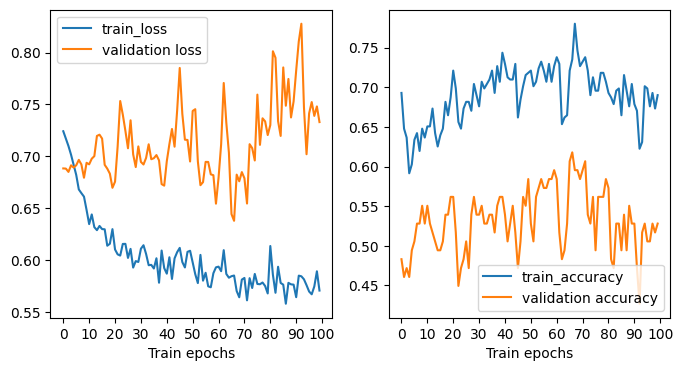

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                5510      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 6,481
Trainable params: 6,481
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.6516128838062286


In [14]:
train_and_evaluate(
    hidden_layer_sizes=[95,10],
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.0012104,
    dropout_rate=0.25,
    num_epochs=100,
    num_folds=10)

| Training accuracy | Validation accuracy |  kernel size |  strides | pool size  |  learning rate | optimizer  | brightness (delta) |  contrast factor | flip_on_train  |
|:-:                |:-:                  |:-:           |:-:       |:-:         |:-:             |:-:         |:-:                 |:-:               |:-:             |